<a href="https://colab.research.google.com/github/prosvirinKir/rzd/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pyreadr

     |████████████████████████████████| 419kB 25.5MB/s 


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from datetime import datetime
sns.set(style="whitegrid", font_scale=1.4)
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from numpy import argmax
from tqdm import trange

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
import pyreadr
from tqdm.notebook import tqdm, trange

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
df = pyreadr.read_r("/content/gdrive/MyDrive/DLS/hw_segmentation/GOR.rds")

# Обработка исходных данных

In [5]:
df = df[None]
df = df.loc[:, (df != df.iloc[0]).any()] 
df = df.drop(df[df.TARGET_2 < 0].index)
pd.set_option("display.max_columns", 200)
df = df.drop(["KODOTS", "RASHIFROVKA", "PROVERENO", "PLUS", "STATUS", "CATEGORY", "KODNAPR", "UPDATTR", "TARGET_1", "TARGET_3"], axis=1)
df["AVG_BALL"] = df["AVG_BALL"].str.replace(',', '.')
df["AVG_KILO"] = df["AVG_KILO"].str.replace(',', '.')
df = df.drop(["LINE"], axis=1)
df = df.drop(['X2179_3', 'X2179_4', 'X2195_3', 'X2195_4', 'X2221_4'], axis = 1) # выкинул признаки, где одно значение

In [6]:
# df_saved = df.copy() # На случай, если в df будет какая-то лажа

In [7]:
# df = df_saved.copy()

In [8]:
# Normalization

target = df['TARGET_2']
df_columns = df.columns

min_max_scaler = preprocessing.MinMaxScaler()
df.loc[:, :] = min_max_scaler.fit_transform(df)
df['TARGET_2'] = target.values

In [9]:
df.reset_index(inplace=True)
df = df.drop(['index'], axis=1)
df

,PCH,YEAR,MONTH,DAY,KM,M,BALL,SPEED_RES_PAS,SPEED_RES_FRE,SPEED_RES_EMPTY,SPEED_NORM_PAS,SPEED_NORM_FRE,LENGTH_KILO,RIX2,RIX3,RIX4,USH2,USH3,USH4,SUG2,SUG3,SUG4,PLU2,PLU3,PLU4,PER2,PER3,PER4,PRO2,PRO3,PRO4,OTS2,OTS3,OTS4,UKL,DRU,AVG_BALL,AVG_KILO,X2049_3,X2049_4,X2065_1,X2065_2,X2065_3,X2065_4,X2067_2,X2067_3,X2067_4,X2081_1,X2081_2,X2081_3,X2081_4,X2097_2,X2097_3,X2097_4,X2113_2,X2113_3,X2113_4,X2129_1,X2129_2,X2129_3,X2129_4,X2145_1,X2145_2,X2145_3,X2145_4,X2161_1,X2161_2,X2161_3,X2161_4,X2177_4,X2193_4,X2209_4,X2211_3,X2211_4,X2213_4,X2215_4,X2218_4,X2221_3,X2222_3,X2222_4,X2223_3,X2223_4,X2226_3,X2226_4,X2227_3,X2227_4,X2228_3,X2228_4,X2229_3,X2229_4,X2230_4,X2231_4,X2232_4,X2233_4,X2243_4,X2244_4,X2246_4,X2289_3,X2289_4,X2290_3,X2290_4,X2291_3,X2291_4,X3199_3,X3312_3,X3313_3,MISTAKES_GROUP,SPEED_RES_PAS_O,SPEED_RES_FRE_O,SPEED_NORM_PAS_O,SPEED_NORM_FRE_O,KR,DZ,T.,Z,IS,UR.PR,PRZH,X.,STRELKA,OBK,MOST,NR,ISM,PR_PREDUPR,EXCLUDE,TARGET_2,DIF_PAS_SP,DIF_FRE_SP,REPAIR_1,REPAIR_2,O_1,O_2,O_3,O_4,O_T,delta_OTS_2,delta_OTS_3,delta_OTS_4,delta_O_1,delta_O_2,delta_O_3,delta_O_4,delta_O_T
0,0.0,0.0,0.000000,0.600000,0.003185,0.0,0.000000,1.0,1.0,1.0,0.3,0.555556,0.326879,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.005291,0.0,0.0,0.0,0.0,0.000000,0.499749,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,0.06,0.030612,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.000000,0.0,0.000000,0,1.0,1.0,0.5,0.5,0.000000,0.005208,0.000000,0.0,0.005128,0.894454,0.978452,0.99403,0.935393,0.896057,0.89356,0.990089,0.853242
1,0.0,0.0,0.000000,0.733333,0.079618,0.0,0.000000,1.0,1.0,1.0,0.7,1.000000,0.327535,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.500753,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,1.0,1.0,0.14,0.071429,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.015873,0.000,0.0,0.0,0.0,0.004902,0.0,0.015873,0,1.0,1.0,0.5,1.0,0.000000,0.000000,0.006803,0.0,0.005128,0.892665,0.978452,0.99403,0.935393,0.894265,0.89356,0.990089,0.851536
2,0.0,0.0,0.000000,0.733333,0.081529,0.0,0.000000,1.0,1.0,1.0,0.8,1.000000,0.328192,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.501756,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.00,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.000000,0.0,0.000000,0,1.0,1.0,0.5,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.891771,0.978452,0.99403,0.935393,0.893369,0.89356,0.990089,0.850683
3,0.0,0.0,0.000000,0.733333,0.082803,0.0,0.000000,1.0,1.0,1.0,0.8,1.000000,0.326223,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.498746,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.00,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000,0.0,

#Отбор признаков

Воспользуемся PCA, чтобы отобрать наиболее значимые признаки

In [35]:
N_FEATURES = 10 # hyperparameter

In [36]:
df_pca = df.drop(['TARGET_2', 'DAY', 'YEAR'], axis=1).copy()
pca_values = PCA(n_components=N_FEATURES).fit_transform(df_pca.values)
df_pca = pd.DataFrame(pca_values)

In [37]:
df_pca['DAY'] = df['DAY']
df_pca['MONTH'] = df['MONTH']
df_pca['YEAR'] = df['YEAR']
df_pca['KM'] = df['KM']
df_pca['TARGET_2'] = df['TARGET_2']

In [38]:
df_pca

,0,1,2,3,4,5,6,7,8,9,DAY,MONTH,YEAR,KM,TARGET_2
0,-0.272544,-0.246019,-0.564300,-0.078993,0.285489,-0.234712,-0.067946,0.035556,-0.042174,-0.235348,0.600000,0.000000,0.0,0.003185,0
1,-0.419410,-0.168065,-0.451503,-0.077379,0.245502,0.110318,-0.417372,0.027256,0.015235,0.121839,0.733333,0.000000,0.0,0.079618,0
2,-0.386077,1.067979,-0.435094,0.112900,0.163002,0.235738,-0.368108,0.096463,0.085752,0.096625,0.733333,0.000000,0.0,0.081529,0
3,-0.247574,1.096450,-0.508567,0.102474,0.136279,-0.184235,-0.155413,0.129693,0.078852,0.069258,0.733333,0.000000,0.0,0.082803,0
4,-0.247612,1.096368,-0.508247,0.102572,0.135100,-0.184213,-0.155321,0.129470,0.078649,0.069341,0.733333,0.000000,0.0,0.084076,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107592,2.495602,-0.322433,-0.420414,-0.085109,0.385958,0.285405,0.457391,-0.245313,-0.066334,0.214308,0.733333,0.454545,1.0,0.016561,0
107593,2.495065,-0.336899,-0.416664,-0.066283,0.376042,0.300071,0.473152,-0.183769,-0.071325,0.172131,0.733333,0.454545,1.0,0.017834,0
107594,2.495335,-0.332785,-0.418999,-0.075721,0.375140,0.296315,0.470747,-0.219785,-0.035707,0.181967,0.733333,0.454545,1.0,0.019108,0
107595,2.495322,-0.334254,-0.417186,-0.067743,0.376336,0.299366,0.472390,-0.203258,-0.071170,0.168054,0.733333,0.454545,1.0,0.021019,0


# Подготовка данных
Данные представляют собой последовательные (заранее отсортированные) наблюдения для *текущего* километра дороги. Для каждого километра их в среднем около 70 штук. 

Т.к. для рекуррентных сетей важно не только текущее наблюдение, но и его предыстория, мы идем "окном" по всем этим наблюдениям. Размер "окна" задается гиперпараметром HISTORY_SIZE. 

Таким образом, эдементарный "кусок" данных, который подается на вход рекуррентной сети, содержит HISTORY_SIZE наблюдений. Каждое наблюдение представялет собой вектор длины FEATURE_NUM - еще один гиперпараметр.

In [39]:
# Здесь для удобства задаем data frame, с которым будем работать
data_frame = df_pca 

# Сортируем по километрам, а каждый километр по дате
data_frame = data_frame.sort_values(["KM", "YEAR", "MONTH", "DAY"])

# Удаляю ненужные признаки
data_frame = data_frame.drop(['YEAR', 'DAY'], axis=1) 

len(list(data_frame))

13

In [205]:
# Размер окна
HISTORY_SIZE = 20

# Шаг окна
STEP = 1

In [206]:
def make_shuffled(X, y):

    # Кол-во объектов
    n_samples = X.shape[0]

    data = torch.utils.data.DataLoader(list(zip(X, y)), batch_size=n_samples, shuffle=True)

    for X_batch, y_batch in data:
        X_shuffled = X_batch
        y_shuffled = y_batch
    
    return X_shuffled, y_shuffled

In [207]:
def make_data(data_frame):

    # Отсортированный список всех километров
    KM_unique = sorted(data_frame.KM.unique())

    # Т.к. в pytorch нет функции append, приходится стакать на нулевые тензоры 
    train = torch.zeros((1, HISTORY_SIZE, data_frame.shape[1]))
    label = torch.zeros((1))
    for km in tqdm(KM_unique):

      df_km = data_frame[data_frame['KM'] == km]

      # Не сдвинутые таргеты
      y_km = df_km['TARGET_2'].values 

      # Сдвигаем все таргеты на один вниз
      df_km['TARGET_2'] = np.hstack((0, y_km[:-1]))

      # Создаем набор данных для каждого км
      cur_km = 0
      max_iter = df_km.shape[0]
      while max_iter >= cur_km + HISTORY_SIZE:

          train_km = df_km.iloc[cur_km:cur_km + HISTORY_SIZE].to_numpy(dtype=np.float16)
          train_km = torch.FloatTensor(train_km)
          train = torch.vstack((train, train_km.unsqueeze(0)))
          label = torch.vstack((label, torch.tensor(y_km[cur_km + HISTORY_SIZE - 1])))
          cur_km += STEP

    return train, label

# Обучение

In [208]:
X, y = make_data(data_frame)

In [209]:
# Сохраним данные
torch.save(X, f'train_hist_{HISTORY_SIZE}_nf_{N_FEATURES}.pt')
torch.save(y, f'label_hist_{HISTORY_SIZE}_nf_{N_FEATURES}.pt')

In [238]:
X = torch.load('train_hist_10_nf_10.pt')
y = torch.load('label_hist_10_nf_10.pt')

In [239]:
y = y.long()

In [240]:
# Объем выборки (кол-во тех самых окошков)
n_samples = X.shape[0]

# Какая часть пойдет в трейн
alpha = 0.8
to_blade = int(n_samples * alpha)

In [241]:
n_samples, to_blade

(93459, 74767)

In [242]:
train_dl = torch.utils.data.DataLoader(list(zip(X[:to_blade], y[:to_blade])), batch_size=512, shuffle=True)
test_dl = torch.utils.data.DataLoader(list(zip(X[to_blade:], y[to_blade:])), batch_size=512, drop_last=True)

In [243]:
def training(model, criterion, optimizer, num_epochs, train_dl, test_dl, scheduler, max_grad_norm=2):
    val_losses = []

    for e in trange(num_epochs, leave=False):
        scheduler.step
        model.train()
        num_iter = 0
        pbar = tqdm(train_dl, leave=False)
        for X_batch, y_batch in pbar:
            optimizer.zero_grad()
            input_embeds = X_batch.to(device)
            labels = y_batch.to(device).flatten()
            prediction = model(input_embeds)
            loss = criterion(prediction, labels)
            loss.backward()
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            num_iter += 1
        valid_loss = 0
        valid_score = 0
        num_iter = 0
        model.eval()
        with torch.no_grad():
            correct = 0
            num_objs = 0
            for X_batch, y_batch in test_dl:
                input_embeds = X_batch.to(device)
                labels = y_batch.to(device).flatten()
                prediction = model(input_embeds)
                valid_loss += criterion(prediction, labels)
                # print(y_batch)
                # print(prediction[:5,1])
                # print("y_batch =", y_batch.flatten())
                valid_score += roc_auc_score(y_batch, prediction[:,1].detach().cpu().numpy())
                # print(valid_score)
                num_iter += 1
        val_losses.append(valid_loss / num_iter)
        print(f"Valid Loss: {valid_loss / num_iter}, mean_roc_auc: {valid_score / num_iter}")
    return val_losses

In [244]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# RNN model

Модель RNN описывается следующим образом::

$$
h_t = \tanh(W_{ih} x_t + b_{ih} + W_{hh} h_{(t-1)} + b_{hh})
$$

In [245]:
class RNN(nn.Module):
    def __init__(self, embed_size, hidden_size):
        super().__init__()

        self.embed_size = embed_size
        self.hidden_size = hidden_size

        self.w_h = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_x = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_x = nn.Parameter(torch.rand(1, hidden_size))

    def forward(self, x, hidden=None):
        '''
        x – torch.FloatTensor with the shape (bs, seq_length, emb_size)
        hidden - torch.FloatTensro with the shape (bs, hidden_size)
        return: torch.FloatTensor with the shape (bs, hidden_size)
        '''
        if hidden is None:
            hidden = torch.zeros((x.size(0), self.hidden_size)).to(x.device)
        seq_length = x.size(1)
        for cur_idx in range(seq_length):
            hidden = torch.tanh(
                x[:, cur_idx] @ self.w_x + self.b_x + hidden @ self.w_h + self.b_h
            )
        return hidden

In [246]:
class RNNModel(nn.Module):
    def __init__(self, embed_size, hidden_size, num_classes=2):
        super().__init__()
        self.rnn = RNN(embed_size, hidden_size)
        self.cls = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        hidden = self.rnn(x)
        hidden = self.cls(hidden)
        return hidden

In [247]:
num_features = len(list(data_frame))
n_hidden = len(list(data_frame))

rnn_model = RNNModel(num_features, n_hidden).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)

num_epochs = 50
max_grad_norm = 1.0

In [248]:
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
val_losses = training(rnn_model, criterion, optimizer, num_epochs, train_dl, test_dl, exp_lr_scheduler, max_grad_norm)

Valid Loss: 0.47999662160873413, mean_roc_auc: 0.5928259025093247


Valid Loss: 0.46474790573120117, mean_roc_auc: 0.6619695525605516


Valid Loss: 0.43953457474708557, mean_roc_auc: 0.710828610213139


Valid Loss: 0.4127272963523865, mean_roc_auc: 0.7435407174549993


Valid Loss: 0.39624568819999695, mean_roc_auc: 0.7579207963650232


Valid Loss: 0.3879881501197815, mean_roc_auc: 0.7653100647069654


Valid Loss: 0.3838741183280945, mean_roc_auc: 0.768133793051743


Valid Loss: 0.38156864047050476, mean_roc_auc: 0.7688563554257495


Valid Loss: 0.3799343407154083, mean_roc_auc: 0.7711203130206356


Valid Loss: 0.37888458371162415, mean_roc_auc: 0.7724491134337035


Valid Loss: 0.378080278635025, mean_roc_auc: 0.7737518947211941


Valid Loss: 0.3771190047264099, mean_roc_auc: 0.7747202693529803


Valid Loss: 0.3766055703163147, mean_roc_auc: 0.7747213086998107


Valid Loss: 0.37692952156066895, mean_roc_auc: 0.7752234820098578


Valid Loss: 0.3755241930484772, mean_roc_auc: 0.7756064614743764


Valid Loss: 0.37486663460731506, mean_roc_auc: 0.7753376601401598


Valid Loss: 0.37650200724601746, mean_roc_auc: 0.7788024647729279


Valid Loss: 0.37561383843421936, mean_roc_auc: 0.7769569348717204


Valid Loss: 0.37397655844688416, mean_roc_auc: 0.7790445729076816


Valid Loss: 0.3752440810203552, mean_roc_auc: 0.779139655113305


Valid Loss: 0.3734742999076843, mean_roc_auc: 0.7790101741008688


Valid Loss: 0.37345224618911743, mean_roc_auc: 0.7797850983373134


Valid Loss: 0.37363162636756897, mean_roc_auc: 0.7789098848457334


Valid Loss: 0.37461382150650024, mean_roc_auc: 0.7791622694709353


Valid Loss: 0.3733404278755188, mean_roc_auc: 0.7786573936712154


Valid Loss: 0.37268874049186707, mean_roc_auc: 0.7803731719674928


Valid Loss: 0.37319856882095337, mean_roc_auc: 0.779906559642647


Valid Loss: 0.37304964661598206, mean_roc_auc: 0.7798018475384237


Valid Loss: 0.37309232354164124, mean_roc_auc: 0.7809376582508027


Valid Loss: 0.37262317538261414, mean_roc_auc: 0.7798995651000358


Valid Loss: 0.3728984296321869, mean_roc_auc: 0.7793838743607461


Valid Loss: 0.37345269322395325, mean_roc_auc: 0.7812029910130556


Valid Loss: 0.37317177653312683, mean_roc_auc: 0.7803381919520095


Valid Loss: 0.3727656900882721, mean_roc_auc: 0.7801844613434252


Valid Loss: 0.3727581799030304, mean_roc_auc: 0.7798457892612638


Valid Loss: 0.37352338433265686, mean_roc_auc: 0.7818511374166988


Valid Loss: 0.37326785922050476, mean_roc_auc: 0.7801416005324877


Valid Loss: 0.3728571832180023, mean_roc_auc: 0.7801685039486916


Valid Loss: 0.3734622001647949, mean_roc_auc: 0.7804253911780071


Valid Loss: 0.37308529019355774, mean_roc_auc: 0.7806814352548327


Valid Loss: 0.37320640683174133, mean_roc_auc: 0.7805621437283176


Valid Loss: 0.3732796311378479, mean_roc_auc: 0.780881210304511


Valid Loss: 0.3734017312526703, mean_roc_auc: 0.7808893362058696


Valid Loss: 0.37320074439048767, mean_roc_auc: 0.7808168878315369


Valid Loss: 0.3733322322368622, mean_roc_auc: 0.7810590249293538


Valid Loss: 0.37386950850486755, mean_roc_auc: 0.7813109110779732


Valid Loss: 0.37331679463386536, mean_roc_auc: 0.7803934839743891


Valid Loss: 0.373147577047348, mean_roc_auc: 0.7815813097599354


Valid Loss: 0.3732958137989044, mean_roc_auc: 0.7813823972782775


Valid Loss: 0.37347549200057983, mean_roc_auc: 0.7825651949239493


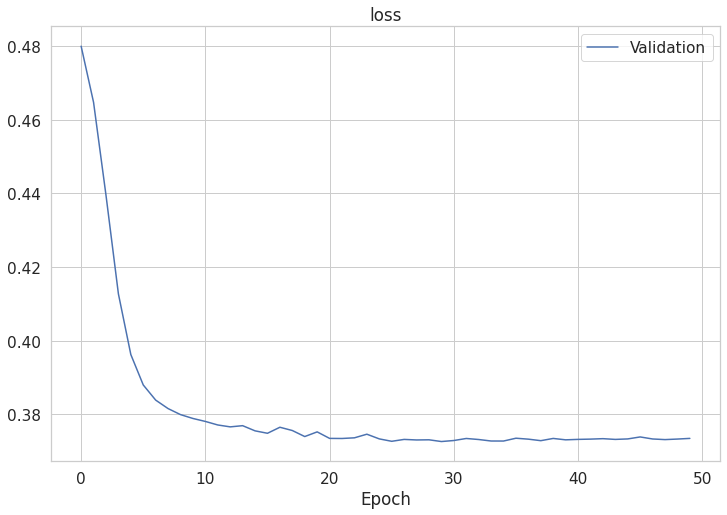

In [249]:
plt.figure(figsize=(12, 8))
# plt.plot(np.arange(len(train_losses) - 1), train_losses[1:], label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('loss')
plt.legend()
plt.show()

In [250]:
test_dl = torch.utils.data.DataLoader(list(zip(X[to_blade:], y[to_blade:])), batch_size=n_samples-to_blade)

In [251]:
for X_batch, y_batch in test_dl:
  preds = rnn_model(X_batch.to(device))
  break

preds = preds.detach().cpu().numpy()

In [252]:
preds.shape, y_batch.shape

((18692, 2), torch.Size([18692, 1]))

In [253]:
test_auc = roc_auc_score(y_batch, preds[:,1])
test_auc

0.8165560197916397

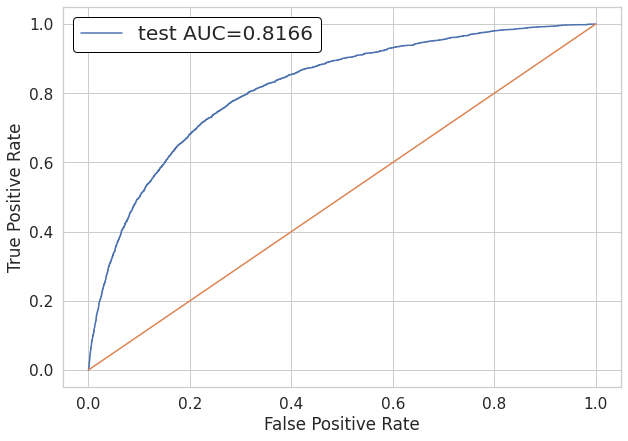

In [254]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_batch, preds[:,1])[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
# plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# GRU model

Модель GRU описывается следующим образом:

$$
\begin{array}{ll}
            r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
            z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
            n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
            h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}
        \end{array}
$$

In [255]:
class GRU(nn.Module):
    def __init__(self, embed_size, hidden_size):
        super().__init__()

        self.embed_size = embed_size
        self.hidden_size = hidden_size

        self.w_rh = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_rh = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_rx = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_rx = nn.Parameter(torch.rand(1, hidden_size))

        self.w_zh = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_zh = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_zx = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_zx = nn.Parameter(torch.rand(1, hidden_size))

        self.w_nh = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_nh = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_nx = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_nx = nn.Parameter(torch.rand(1, hidden_size))

    def forward(self, x, hidden = None):
        '''
        x – torch.FloatTensor with the shape (bs, seq_length, emb_size)
        hidden - torch.FloatTensro with the shape (bs, hidden_size)
        return: torch.FloatTensor with the shape (bs, hidden_size)
        '''
        if hidden is None:
            hidden = torch.zeros((x.size(0), self.hidden_size)).to(x.device)
        
        for cur_idx in range(x.size(1)):
            r = torch.sigmoid(
                x[:, cur_idx] @ self.w_rx + self.b_rx + hidden @ self.w_rh + self.b_rh
            )
            z = torch.sigmoid(
                x[:, cur_idx] @ self.w_zx + self.b_zx + hidden @ self.w_zh + self.b_zh
            )
            n = torch.tanh(
                x[:, cur_idx] @ self.w_nx + self.b_nx + r * (hidden @ self.w_nh + self.b_nh)
            )
            hidden = (1 - z) * n + z * hidden

        return hidden

In [256]:
class GRUModel(nn.Module):
    def __init__(self, embed_size, hidden_size, num_classes=2):
        super().__init__()
        self.gru = GRU(embed_size, hidden_size)
        self.cls = nn.Linear(hidden_size, num_classes)
        # self.softmax = nn.Softmax()

    def forward(self, x):
        hidden = self.gru(x)
        hidden = self.cls(hidden)
        # hidden = self.softmax(hidden)
        return hidden

In [266]:
num_features = len(list(data_frame))
n_hidden = len(list(data_frame))

gru_model = GRUModel(num_features, n_hidden).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=1e-3)

num_epochs = 50
max_grad_norm = 1.0

In [267]:
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
val_losses = training(gru_model, criterion, optimizer, num_epochs, train_dl, test_dl, exp_lr_scheduler, max_grad_norm)

Valid Loss: 0.47018980979919434, mean_roc_auc: 0.6027355107621849


Valid Loss: 0.4625307619571686, mean_roc_auc: 0.6520956427399278


Valid Loss: 0.4527038633823395, mean_roc_auc: 0.688487861293798


Valid Loss: 0.44277966022491455, mean_roc_auc: 0.7118766825023296


Valid Loss: 0.4332889914512634, mean_roc_auc: 0.7242949422791389


Valid Loss: 0.4268065392971039, mean_roc_auc: 0.7323746625817645


Valid Loss: 0.4210079610347748, mean_roc_auc: 0.7408211293275857


Valid Loss: 0.41520941257476807, mean_roc_auc: 0.7475369298603561


Valid Loss: 0.4080061614513397, mean_roc_auc: 0.7568059939847193


Valid Loss: 0.3988805413246155, mean_roc_auc: 0.7717268450578734


Valid Loss: 0.3864554762840271, mean_roc_auc: 0.7906249862691205


Valid Loss: 0.37979641556739807, mean_roc_auc: 0.8033311118553446


Valid Loss: 0.37941160798072815, mean_roc_auc: 0.8090284734360478


Valid Loss: 0.37702107429504395, mean_roc_auc: 0.8126624892076475


Valid Loss: 0.3749805688858032, mean_roc_auc: 0.8150117987129808


Valid Loss: 0.37526431679725647, mean_roc_auc: 0.81671098495282


Valid Loss: 0.37515774369239807, mean_roc_auc: 0.8174905375099858


Valid Loss: 0.37296444177627563, mean_roc_auc: 0.8182553106477044


Valid Loss: 0.37524276971817017, mean_roc_auc: 0.8190182577567653


Valid Loss: 0.3729572296142578, mean_roc_auc: 0.8192152881510313


Valid Loss: 0.3742852807044983, mean_roc_auc: 0.8193276079346045


Valid Loss: 0.3741520643234253, mean_roc_auc: 0.8199721675190321


Valid Loss: 0.37106508016586304, mean_roc_auc: 0.8203961865902274


Valid Loss: 0.3738894760608673, mean_roc_auc: 0.8205601487467727


Valid Loss: 0.37212517857551575, mean_roc_auc: 0.8204652142777105


Valid Loss: 0.3696589171886444, mean_roc_auc: 0.8207743171808355


Valid Loss: 0.37111422419548035, mean_roc_auc: 0.8208679201706681


Valid Loss: 0.3712555766105652, mean_roc_auc: 0.821051550177546


Valid Loss: 0.3703995645046234, mean_roc_auc: 0.8209759506890092


Valid Loss: 0.371703565120697, mean_roc_auc: 0.8212766747835543


Valid Loss: 0.369826078414917, mean_roc_auc: 0.8214088716499103


Valid Loss: 0.37148317694664, mean_roc_auc: 0.8210044823867838


Valid Loss: 0.3716728091239929, mean_roc_auc: 0.8215115477196354


Valid Loss: 0.3710837662220001, mean_roc_auc: 0.8214476081849225


Valid Loss: 0.37158170342445374, mean_roc_auc: 0.821722939068448


Valid Loss: 0.3694486618041992, mean_roc_auc: 0.8217709293841051


Valid Loss: 0.37149977684020996, mean_roc_auc: 0.8215894392545604


Valid Loss: 0.37045934796333313, mean_roc_auc: 0.8214611797624973


Valid Loss: 0.3682544231414795, mean_roc_auc: 0.8214515455592153


Valid Loss: 0.369356244802475, mean_roc_auc: 0.8217515278296182


Valid Loss: 0.3686094880104065, mean_roc_auc: 0.8218573233649669


Valid Loss: 0.3693159222602844, mean_roc_auc: 0.8218080396123439


Valid Loss: 0.3714678883552551, mean_roc_auc: 0.8215648068888148


Valid Loss: 0.36961016058921814, mean_roc_auc: 0.8213767639793479


Valid Loss: 0.3699769973754883, mean_roc_auc: 0.821411315865353


Valid Loss: 0.3689912259578705, mean_roc_auc: 0.8214384875522005


Valid Loss: 0.3690125644207001, mean_roc_auc: 0.8217461924021344


Valid Loss: 0.370034784078598, mean_roc_auc: 0.8214904913266777


Valid Loss: 0.37098169326782227, mean_roc_auc: 0.8212919392418637


Valid Loss: 0.37051665782928467, mean_roc_auc: 0.8213250645429802


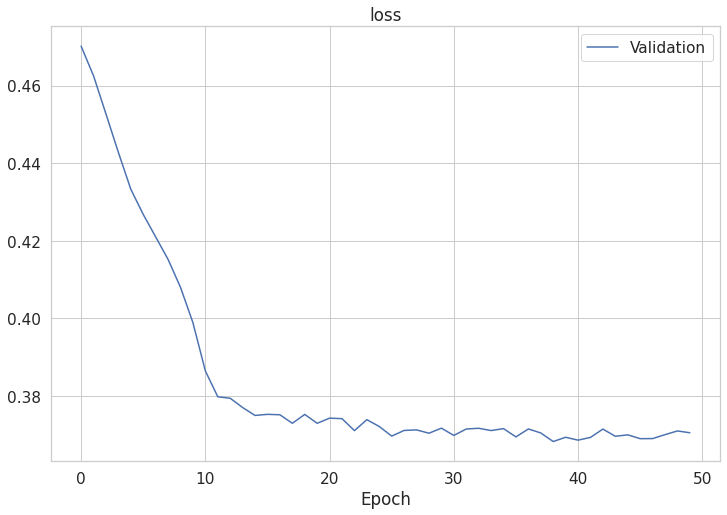

In [268]:
plt.figure(figsize=(12, 8))
# plt.plot(np.arange(len(train_losses) - 1), train_losses[1:], label='Train')
plt.plot(np.arange(len(val_losses) ), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('loss')
plt.legend()
plt.show()

In [269]:
test_dl = torch.utils.data.DataLoader(list(zip(X[to_blade:], y[to_blade:])), batch_size=n_samples-to_blade)

In [270]:
for X_batch, y_batch in test_dl:
  preds = gru_model(X_batch.to(device))
  break

In [271]:
preds = preds.detach().cpu().numpy()

In [272]:
preds.shape #, preds[:20]

(18692, 2)

In [273]:
test_auc = roc_auc_score(y_batch, preds[:,1])
test_auc

0.8213250645429802

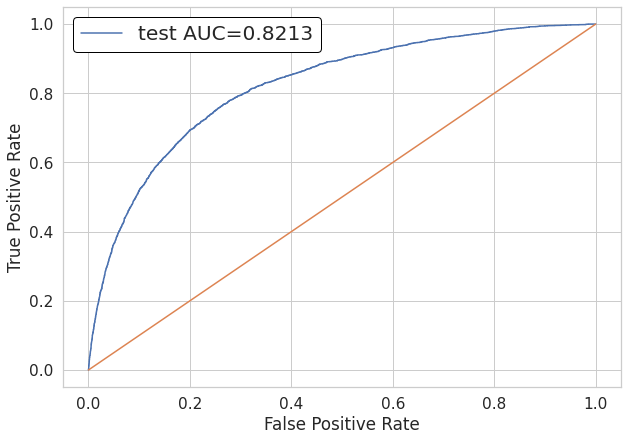

In [274]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_batch, preds[:,1])[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
# plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()